# Store Sales - Time Series Forecasting 


<img src='https://drive.google.com/uc?export=view&id=1g2YT_grNukNIA79WR9c02naVEZju5u8e' width=25000px>

## **`Business problem statement`**

In this “getting started” competition, you’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer.

Specifically, you'll build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores. You'll practice your machine learning skills with an approachable training dataset of dates, store, and item information, promotions, and unit sales.

## **`Dataset Description`**

In this competition, you will predict sales for the thousands of product families sold at Favorita stores located in Ecuador. The training data includes dates, store and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models.

## **`File Descriptions and Data Field Information`**

`train.csv` :

The training data, comprising time series of features store_nbr, family, and onpromotion as well as the target sales.
store_nbr identifies the store at which the products are sold.
family identifies the type of product sold.
sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of cheese, for instance, as opposed to 1 bag of chips).
onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

`test.csv` :

The test data, having the same features as the training data. You will predict the target sales for the dates in this file.
The dates in the test data are for the 15 days after the last date in the training data.

`sample_submission.csv` : 

A sample submission file in the correct format.
stores.csv
Store metadata, including city, state, type, and cluster.
cluster is a grouping of similar stores.

`oil.csv` : 

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

`holidays_events.csv` : 

Holidays and Events, with metadata
NOTE: Pay special attention to the transferred column. A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer. For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

`Additional Notes` : 

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

<img src='https://drive.google.com/uc?export=view&id=1Vjxyj0RL7uYkNQ0xpMiILOPUJpAVpc7l' width=1000px>


## `Evaluation` :
The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:

$$RMSLE = \sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}$$

where:

 $n$ is the total number of instances,

 $\hat{y}_i$ is the predicted value of the target for instance (i),

 ${y}_i$ is the actual value of the target for instance (i)
 
 $log$ is the natural logarithm.

# Install and import libraries

In [1]:
!pip install opendatasets -q
!pip install xgboost -q

In [2]:
#Data Importing
import opendatasets as od
import os
import calendar
from datetime import datetime

# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib as plt
import matplotlib.pyplot as plt
from pylab import rcParams
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
%matplotlib inline 

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor


# Download and extract data

In [3]:
dataset_url='https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data'

In [4]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: iyumrahul
Your Kaggle Key: ··········


100%|██████████| 21.4M/21.4M [00:00<00:00, 36.7MB/s]



Extracting archive ./store-sales-time-series-forecasting/store-sales-time-series-forecasting.zip to ./store-sales-time-series-forecasting


In [5]:
!ls -lh ./store-sales-time-series-forecasting

total 119M
-rw-r--r-- 1 root root  22K Feb 28 00:44 holidays_events.csv
-rw-r--r-- 1 root root  21K Feb 28 00:44 oil.csv
-rw-r--r-- 1 root root 335K Feb 28 00:44 sample_submission.csv
-rw-r--r-- 1 root root 1.4K Feb 28 00:44 stores.csv
-rw-r--r-- 1 root root 999K Feb 28 00:44 test.csv
-rw-r--r-- 1 root root 117M Feb 28 00:44 train.csv
-rw-r--r-- 1 root root 1.5M Feb 28 00:44 transactions.csv


## Reading the data

In [6]:
%%time
holiday_data=pd.read_csv('/content/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'])

oil_data=pd.read_csv('/content/store-sales-time-series-forecasting/oil.csv', parse_dates=['date'], dtype={'dcoilwtico' :'float32'})

store_data=pd.read_csv('/content/store-sales-time-series-forecasting/stores.csv', dtype={'store_nbr':'int16','cluster':'int16'})

transaction_data=pd.read_csv('/content/store-sales-time-series-forecasting/transactions.csv', parse_dates=['date'], dtype={'store_nbr':'int16','transactions':'int32'})

test_data=pd.read_csv('/content/store-sales-time-series-forecasting/test.csv', parse_dates=['date'], dtype= {'id':'int16','store_nbr':'int16','onpromotion':'int16'} )

train_data=pd.read_csv('/content/store-sales-time-series-forecasting/train.csv', parse_dates=['date'], dtype={'id':'int16','store_nbr':'int16','sales':'float32','onpromotion':'int32'} )

CPU times: user 2.76 s, sys: 495 ms, total: 3.25 s
Wall time: 4.58 s


# Exploring the data

**Train Dataset** 

In [7]:
print(train_data.head())

print('Null values in training set ',train_data.isna().sum())

   id       date  store_nbr      family  sales  onpromotion
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0
1   1 2013-01-01          1   BABY CARE    0.0            0
2   2 2013-01-01          1      BEAUTY    0.0            0
3   3 2013-01-01          1   BEVERAGES    0.0            0
4   4 2013-01-01          1       BOOKS    0.0            0
Null values in training set  id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [8]:
train_data.family.unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [9]:
def replace_fam_vals(df):
  df.replace('BABY CARE','BABY_CARE',inplace=True)
  df.replace('BREAD/BAKERY','BREAD_BAKERY',inplace=True)
  df.replace('FROZEN FOODS','FROZEN_FOODS',inplace=True)
  df.replace('GROCERY I','GROCERY_I',inplace=True)
  df.replace('GROCERY II','GROCERY_II',inplace=True)
  df.replace('HOME APPLIANCES','HOME_APPLIANCES',inplace=True)
  df.replace('HOME CARE','HOME_CARE',inplace=True)
  df.replace('HOME AND KITCHEN I','HOME_AND_KITCHEN_I',inplace=True)
  df.replace('HOME AND KITCHEN II','HOME_AND_KITCHEN_II',inplace=True)
  df.replace('LAWN AND GARDEN','LAWN_AND_GARDEN',inplace=True)
  df.replace('LIQUOR,WINE,BEER','LIQUOR_WINE_BEER',inplace=True)
  df.replace('PERSONAL CARE','PERSONAL_CARE',inplace=True)
  df.replace('PET SUPPLIES','PET_SUPPLIES',inplace=True)
  df.replace('PLAYERS AND ELECTRONICS','PLAYERS_AND_ELECTRONICS',inplace=True)
  df.replace('PREPARED FOODS','PREPARED_FOODS',inplace=True)
  df.replace('SCHOOL AND OFFICE SUPPLIES','SCHOOL_AND_OFFICE_SUPPLIES',inplace=True)
  return df

In [10]:
replace_fam_vals(train_data.family)

0                          AUTOMOTIVE
1                           BABY_CARE
2                              BEAUTY
3                           BEVERAGES
4                               BOOKS
                      ...            
3000883                       POULTRY
3000884                PREPARED_FOODS
3000885                       PRODUCE
3000886    SCHOOL_AND_OFFICE_SUPPLIES
3000887                       SEAFOOD
Name: family, Length: 3000888, dtype: object

**Test Dataset**

In [11]:
print(test_data.head())

print('Null values in testing set ',test_data.isna().sum())

      id       date  store_nbr      family  onpromotion
0 -13768 2017-08-16          1  AUTOMOTIVE            0
1 -13767 2017-08-16          1   BABY CARE            0
2 -13766 2017-08-16          1      BEAUTY            2
3 -13765 2017-08-16          1   BEVERAGES           20
4 -13764 2017-08-16          1       BOOKS            0
Null values in testing set  id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


In [12]:
test_data.date.max(),test_data.date.min()

(Timestamp('2017-08-31 00:00:00'), Timestamp('2017-08-16 00:00:00'))

In [13]:
replace_fam_vals(test_data.family)

0                        AUTOMOTIVE
1                         BABY_CARE
2                            BEAUTY
3                         BEVERAGES
4                             BOOKS
                    ...            
28507                       POULTRY
28508                PREPARED_FOODS
28509                       PRODUCE
28510    SCHOOL_AND_OFFICE_SUPPLIES
28511                       SEAFOOD
Name: family, Length: 28512, dtype: object

**Store Dataset**

In [14]:
print(store_data.head())

print('Null values in store dataset ',store_data.isna().sum())

   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
Null values in store dataset  store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


**Transaction Dataset**

In [15]:
print(transaction_data.head())

print('Null values in transaction dataset ',transaction_data.isna().sum())

        date  store_nbr  transactions
0 2013-01-01         25           770
1 2013-01-02          1          2111
2 2013-01-02          2          2358
3 2013-01-02          3          3487
4 2013-01-02          4          1922
Null values in transaction dataset  date            0
store_nbr       0
transactions    0
dtype: int64


**Oil Dataset**

In [16]:
print(oil_data.head())

print('Null values in Oil dataset ',oil_data.isna().sum())

        date  dcoilwtico
0 2013-01-01         NaN
1 2013-01-02   93.139999
2 2013-01-03   92.970001
3 2013-01-04   93.120003
4 2013-01-07   93.199997
Null values in Oil dataset  date           0
dcoilwtico    43
dtype: int64


In [17]:
oil_data.describe()

,dcoilwtico
count,1175.000000
mean,67.714363
std,25.630476
min,26.190001
25%,46.404999
50%,53.189999
75%,95.660004
max,110.620003


In [18]:
oil_data.dcoilwtico[0]=93.00

for i in list(oil_data[oil_data.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([oil_data.dcoilwtico[p],oil_data.dcoilwtico[c]])
  oil_data.dcoilwtico[i]=mean

oil_data[oil_data.dcoilwtico.isna()]

,date,dcoilwtico
1174,2017-07-03,NaN
1175,2017-07-04,NaN


In [19]:
print(oil_data.loc[1173])
oil_data.dcoilwtico[1174]=46.02
oil_data.dcoilwtico[1175]=46.02

date          2017-06-30 00:00:00
dcoilwtico                  46.02
Name: 1173, dtype: object


**Holiday Dataset** 

In [20]:
holiday_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


**Additional Earthquake**

In [21]:
earthquake = holiday_data[holiday_data['description'].str.startswith('Terremoto Manabi')]
earthquake = earthquake[['date', 'description']].reset_index(drop=True)
earthquake.rename({'description': 'earthquake'}, axis=1, inplace=True)
earthquake

,date,earthquake
0,2016-04-16,Terremoto Manabi
1,2016-04-17,Terremoto Manabi+1
2,2016-04-18,Terremoto Manabi+2
3,2016-04-19,Terremoto Manabi+3
4,2016-04-20,Terremoto Manabi+4
5,2016-04-21,Terremoto Manabi+5
6,2016-04-22,Terremoto Manabi+6
7,2016-04-23,Terremoto Manabi+7
8,2016-04-24,Terremoto Manabi+8
9,2016-04-25,Terremoto Manabi+9


**Additional Holidays (New Year)**

In [22]:
additional_date = ['2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01', '2016-01-01', '2017-01-01']
additional_holidays = pd.DataFrame({'date':additional_date, 'locale':'National',
                                    'locale_name':'Ecuador','transferred':False})
additional_holidays['date'] = pd.to_datetime(additional_holidays['date'])
additional_holidays

,date,locale,locale_name,transferred
0,2012-01-01,National,Ecuador,False
1,2013-01-01,National,Ecuador,False
2,2014-01-01,National,Ecuador,False
3,2015-01-01,National,Ecuador,False
4,2016-01-01,National,Ecuador,False
5,2017-01-01,National,Ecuador,False


In [23]:

holiday_data = holiday_data.drop_duplicates()
holiday_data = pd.concat([holiday_data.reset_index(drop=True),  additional_holidays.reset_index(drop=True)], axis=0)
holiday_data

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
1,2013-01-01,NaN,National,Ecuador,NaN,False
2,2014-01-01,NaN,National,Ecuador,NaN,False
3,2015-01-01,NaN,National,Ecuador,NaN,False
4,2016-01-01,NaN,National,Ecuador,NaN,False


Merging the train dataset with stores dataset

In [24]:
train_data =train_data.merge(store_data ,how = 'left', on = 'store_nbr')
test_data = test_data.merge(store_data, how = 'left', on = 'store_nbr')

Merging the train dataset with holidays dataset

In [25]:
train_data = train_data.merge(holiday_data,how = 'left', on = ['date'])
test_data = test_data.merge(holiday_data,how = 'left', on = ['date'])

Merging the train dataset with oil dataset

In [26]:
train_data =pd.merge(train_data,oil_data, how = 'left', on = 'date')
test_data = pd.merge(test_data,oil_data, how = 'left', on = 'date')

In [27]:
train_data.rename(columns = {'type_x': 'store_type'},inplace=True)
test_data.rename(columns = {'type_x': 'store_type'},inplace=True)

In [28]:
train_data.rename(columns = {'type_y': 'type'},inplace=True)
test_data.rename(columns = {'type_y': 'type'},inplace=True)

In [29]:
train_data.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,type,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.0
1,0,2013-01-01,1,AUTOMOTIVE,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,NaN,False,93.0
2,1,2013-01-01,1,BABY_CARE,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.0
3,1,2013-01-01,1,BABY_CARE,0.0,0,Quito,Pichincha,D,13,NaN,National,Ecuador,NaN,False,93.0
4,2,2013-01-01,1,BEAUTY,0.0,0,Quito,Pichincha,D,13,Holiday,National,Ecuador,Primer dia del ano,False,93.0


In [30]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'type', 'locale', 'locale_name',
       'description', 'transferred', 'dcoilwtico'],
      dtype='object')

In [31]:
train_data.shape

(3063258, 16)

In [32]:
test_data.shape

(28512, 15)

In [33]:
train_data.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
type           2560734
locale         2551824
locale_name    2551824
description    2560734
transferred    2551824
dcoilwtico      880308
dtype: int64

Imputing missing Values

In [34]:
# Apart from holidays all are working days
train_data['type'].fillna('working_day',inplace=True)
test_data['type'].fillna('working_day',inplace=True)

# All the NaN value in 'locale' column are working days hence it is National
train_data['locale'].fillna('National', inplace=True)
test_data['locale'].fillna('National', inplace=True)

# All the NaN value in 'locale' column are working days hence it is National
train_data['description'].fillna('Unkown', inplace=True)
test_data['description'].fillna('Unkown', inplace=True)

# Filling the blanks with the value before nan
train_data['dcoilwtico'].fillna(method = 'ffill', inplace=True)
test_data['dcoilwtico'].fillna(method = 'ffill', inplace=True)

# All the NaN values are working days hence not tranferred
train_data['transferred'].fillna(False, inplace=True)
test_data['transferred'].fillna(False, inplace=True)

In [35]:
train_data.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
city                 0
state                0
store_type           0
cluster              0
type                 0
locale               0
locale_name    2551824
description          0
transferred          0
dcoilwtico           0
dtype: int64

# Feature Engineering

This function performs the following feature engineering tasks:
The `holiday_feature_engineering` function takes a pandas DataFrame that contains information about holidays and events as input, and it returns a modified DataFrame that includes new columns representing useful features derived from the original data.

Here's a brief summary of what the function does:

First, it makes a copy of the input DataFrame to avoid modifying the original data.
Next, it converts the 'date' column to a datetime data type, and it creates new columns for the year, month, day, and weekday of each holiday/event date.
It fills any missing values in the 'type' column with 'Work Day'.
It creates a new column called 'is_holiday' which is True for rows where the 'type' column is not 'Work Day'.
It creates a new column called 'is_transfer' which is True for rows where the 'type' column is 'Transfer'.
It creates a new column called 'is_additional' which is True for rows where the 'type' column starts with 'Additional'.
Finally, it drops the original 'type' column since the new columns created from it provide more detailed information about each holiday/event.

In [36]:
import pandas as pd
import numpy as np

def holiday_feature_engineering(df):
    # convert date column to datetime
    df_copy = df.copy()
    df_copy['date'] = pd.to_datetime(df_copy['date'], format='%Y-%m-%d')

    # create year, month, day, and weekday columns
    df_copy['year'] = df_copy['date'].dt.year
    df_copy['month'] = df_copy['date'].dt.month
    df_copy['day'] = df_copy['date'].dt.day
    df_copy['weekday'] = df_copy['date'].dt.day_name()

    # fill NaN values in type column with 'Work Day'
    df_copy['type'].fillna('Work Day', inplace=True)

    # create binary column for holidays and work days
    df_copy['is_holiday'] = np.where((df_copy['type'] != 'Work Day') & (df_copy['transferred'] == False), 1, 0)
    df_copy['is_work_day'] = np.where((df_copy['type'] == 'Work Day') | (df_copy['transferred'] == True), 1, 0)

    # group by year, month, and is_holiday columns to get holiday count per month
    holidays_per_month = df_copy.groupby(['year', 'month', 'is_holiday'], as_index=False)['date'].count()
    holidays_per_month.rename(columns={'date': 'holiday_count'}, inplace=True)
    holidays_per_month = holidays_per_month[holidays_per_month['is_holiday'] == 1]

    # merge holiday count per month with original dataframe
    df_copy = pd.merge(df_copy, holidays_per_month[['year', 'month', 'holiday_count']], on=['year', 'month'], how='left')

    return df_copy


In [37]:
train_data=holiday_feature_engineering(train_data)
test_data=holiday_feature_engineering(test_data)

In [38]:
train_data.date.min()

Timestamp('2013-01-01 00:00:00')

In [39]:
train_data.isna().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
store_type             0
cluster                0
type                   0
locale                 0
locale_name      2551824
description            0
transferred            0
dcoilwtico             0
year                   0
month                  0
day                    0
weekday                0
is_holiday             0
is_work_day            0
holiday_count          0
dtype: int64

In [40]:
def wage_feature_engineering(df):
    # Convert date column to datetime format
    df['date'] = pd.to_datetime(df['date'])
    
    # Create a new column for day of the month
    df['day'] = df['date'].dt.day
    
    # Create a new column for whether the day is a pay day or not
    df['pay_day'] = ((df['day'] == 15) | (df['day'] == df['date'].dt.daysinmonth)).astype(int)
    
    # Create a new column for whether the previous day was a pay day or not
    df['prev_pay_day'] = df['pay_day'].shift(1).fillna(0)
    
    return df


This function takes a pandas DataFrame as input, and assumes that it contains a 'date' column in string format (e.g. '2019-01-01'). The function first converts this column to a pandas datetime format so that it can be used for date calculations.

Next, the function creates a new 'day' column that contains the day of the month (1-31) for each date in the DataFrame.

The function then creates a new binary 'pay_day' column that is 1 for the 15th and last day of the month, and 0 otherwise. This column is created using a boolean expression that checks if the 'day' column is equal to 15 or the number of days in the month, which is obtained using the '.dt.daysinmonth' method.

Finally, the function creates another binary 'prev_pay_day' column that indicates whether the previous day was a pay day or not. This is done by shifting the 'pay_day' column by one day using the '.shift(1)' method, and filling in the first missing value with 0 using the '.fillna(0)' method.

These features could then be used in a machine learning model to help capture the potential impact of bi-weekly public sector wages on supermarket sales.

In [41]:
train_data = wage_feature_engineering(train_data)
test_data = wage_feature_engineering(test_data)

In [42]:
train_data.isna().sum()

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
store_type             0
cluster                0
type                   0
locale                 0
locale_name      2551824
description            0
transferred            0
dcoilwtico             0
year                   0
month                  0
day                    0
weekday                0
is_holiday             0
is_work_day            0
holiday_count          0
pay_day                0
prev_pay_day           0
dtype: int64

In [43]:
def extract_earthquake_feature(df, col_name):
    """
    Extracts the earthquake feature from a pandas DataFrame.

    Parameters:
    df (pandas.DataFrame): The DataFrame to extract the feature from.
    col_name (str): The name of the column containing the event descriptions.

    Returns:
    pandas.Series: A binary series indicating whether an earthquake occurred on each day.
    """

    # Create new binary feature indicating whether an earthquake occurred
    has_earthquake = df[col_name].str.contains('Terremoto').astype(int)

    return has_earthquake


In [44]:
train_data['has_earthquake'] = extract_earthquake_feature(train_data, 'description')
test_data['has_earthquake'] = extract_earthquake_feature(test_data, 'description')

In [45]:
train_data.drop(['locale_name','description'],axis=1,inplace=True)
test_data.drop(['locale_name','description'],axis=1,inplace=True)

In [46]:
train_data.shape

(3063258, 24)

In [47]:
test_data.shape

(28512, 23)

# Exploratory Data Analysis

## Data available in each year

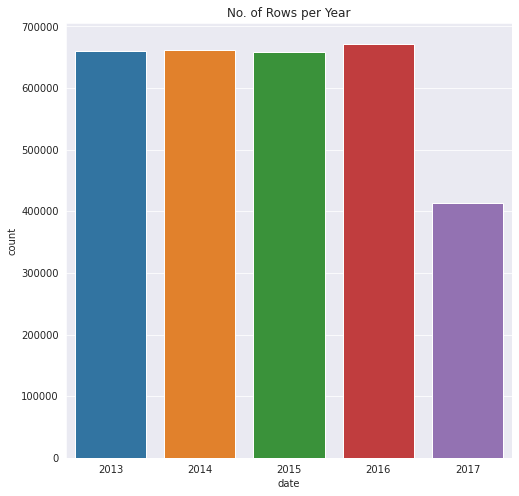

In [48]:
plt.figure(figsize=(8, 8))
sns.countplot(x=pd.to_datetime(train_data.date).dt.year)
plt.title('No. of Rows per Year')
plt.show();

## Correlations

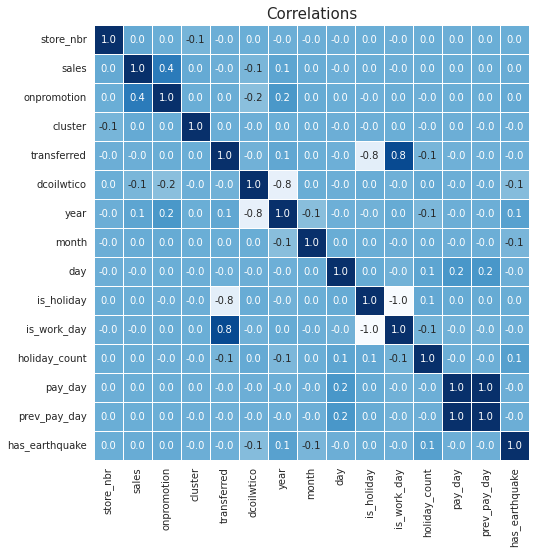

In [49]:
plt.figure(figsize=(15, 8))
sns.heatmap(train_data[train_data.columns[1:]].corr(),
        annot=True,
        fmt='.1f',
        cmap='Blues',
        square=True,
        linewidths=1,
        cbar=False)
plt.title("Correlations",fontsize = 15)
plt.show()

## **Asking Questions**

### 1. Did Earhquake affect the store sales?
There's an additional note about the data
<img src='https://drive.google.com/uc?export=view&id=1OdZuv-Ug5eYcZbdBxxCr1WDPPcv8vsE0' width=1000px>


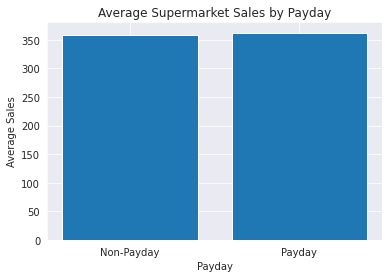

In [50]:
# Group the sales data by payday and calculate the average sales for each group
avg_sales_by_payday = train_data.groupby('pay_day')['sales'].mean()

# Plot the average sales by payday
plt.bar(['Non-Payday', 'Payday'], avg_sales_by_payday)
plt.title('Average Supermarket Sales by Payday')
plt.xlabel('Payday')
plt.ylabel('Average Sales')
plt.show()

`Observations` :    
Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales are **not affected by this**.

In [51]:
# March
march= pd.pivot_table(train_data[(train_data.date.dt.month.isin([3]))], 
               index=train_data.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
march

family,AUTOMOTIVE,BABY_CARE,BEAUTY,BEVERAGES,BOOKS,BREAD_BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL_CARE,PET_SUPPLIES,PLAYERS_AND_ELECTRONICS,POULTRY,PREPARED_FOODS,PRODUCE,SCHOOL_AND_OFFICE_SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013,4.560932,0.000000,2.330347,1088.542358,0.000000,354.853516,0.000000,899.277161,365.894867,195.494293,...,0.000000,313.938690,190.713257,0.000000,0.000000,190.441727,90.362183,2.411589,0.000000,23.941057
2014,6.042413,0.043011,3.086021,2646.471924,0.000000,388.987701,12.830346,1057.511353,709.575256,227.415344,...,1.170251,332.993347,231.297485,4.785543,9.594385,390.943054,97.848579,2002.596313,1.335125,23.890751
2015,6.902031,0.000000,2.538232,1385.922363,0.000000,500.669403,0.000000,1115.107544,737.664856,301.454895,...,0.000000,326.473816,289.569885,0.000000,0.000000,384.931152,95.655190,4.124851,0.000000,26.169935
2016,7.203106,0.264038,4.261051,2967.511963,0.000000,492.651520,13.970132,1057.762817,843.405029,272.667236,...,5.959976,324.644165,290.982666,5.780765,8.557945,368.022827,107.821007,2262.134521,1.922342,23.449707
2017,7.642772,0.264038,4.212067,3664.010254,0.281959,573.421265,13.947432,1197.510742,972.788513,320.441528,...,6.161888,367.350983,325.296906,8.627837,11.180407,388.023895,111.916695,2396.963135,4.925926,25.063908


In [52]:
march= march.sum(axis=1).reset_index()
march['month']= 'march'

In [53]:
# April
april= pd.pivot_table(train_data[(train_data.date.dt.month.isin([4]))], 
               index=train_data.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
april

family,AUTOMOTIVE,BABY_CARE,BEAUTY,BEVERAGES,BOOKS,BREAD_BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL_CARE,PET_SUPPLIES,PLAYERS_AND_ELECTRONICS,POULTRY,PREPARED_FOODS,PRODUCE,SCHOOL_AND_OFFICE_SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013,4.620370,0.000000,2.265432,1076.000610,0.000000,351.001984,0.000000,877.299988,345.425934,195.162781,...,0.000000,321.711823,201.569748,0.000000,0.000000,188.420074,80.945480,3.893827,0.000000,21.172472
2014,5.201234,0.000000,2.394444,1304.398193,0.000000,353.837921,0.000000,896.440735,678.221619,215.213913,...,0.000000,302.611755,225.521606,0.000000,0.000000,347.227844,92.550209,4.414815,0.000000,19.701996
2015,5.584568,0.000000,2.467901,1424.164795,0.000000,493.748901,0.000000,1129.893188,729.123474,296.434967,...,1.345679,322.410065,280.970978,0.000000,0.000000,372.965118,95.475380,4.421605,0.000000,24.681154
2016,7.145759,0.225806,5.077658,3529.085938,0.000000,525.742310,14.065711,1226.231812,874.803467,291.756439,...,6.841697,358.389191,390.849457,6.707288,11.523895,395.592438,108.034630,2217.003418,5.556750,24.055408
2017,8.161290,0.185783,4.617085,3649.302246,0.161888,539.214478,13.926523,1236.851807,960.898438,318.637543,...,7.077061,351.644806,335.820190,9.063321,12.238949,372.121277,101.319824,2303.228760,17.576464,22.631514


In [54]:
april= april.sum(axis=1).reset_index()
april['month']= 'april'

In [55]:
# May
may= pd.pivot_table(train_data[(train_data.date.dt.month.isin([5]))], 
               index=train_data.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")
may

family,AUTOMOTIVE,BABY_CARE,BEAUTY,BEVERAGES,BOOKS,BREAD_BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL_CARE,PET_SUPPLIES,PLAYERS_AND_ELECTRONICS,POULTRY,PREPARED_FOODS,PRODUCE,SCHOOL_AND_OFFICE_SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013,5.378472,0.000000,2.226852,1096.029541,0.0000,369.368378,0.000000,885.340881,356.175934,208.577560,...,0.000000,325.077484,184.948502,0.000000,0.000000,193.017914,85.113380,5.654514,0.000000,22.309168
2014,4.823775,0.000000,2.163680,1243.594971,0.0000,371.376617,0.000000,895.068115,658.005981,226.424026,...,0.000000,327.115540,238.545990,0.000000,0.000000,358.785248,87.823662,5.432497,0.000000,21.444462
2015,5.572879,0.000000,3.011947,2111.170898,0.0000,527.189026,0.000000,1143.790283,772.585449,314.021210,...,1.768220,353.459930,300.913391,0.111111,0.000000,396.078827,94.243752,6.076464,0.000000,25.392372
2016,7.206878,0.283069,4.660317,3192.553467,0.0000,564.665771,13.887831,1188.984619,930.013733,300.740814,...,6.860847,357.126556,338.059265,6.907407,9.784127,391.916992,106.388954,2309.795166,7.102645,24.105692
2017,7.059737,0.166667,5.900239,3487.099854,0.0908,566.843262,13.338112,1352.649902,966.421143,322.572418,...,6.640980,367.788177,310.506561,8.976703,12.050776,392.489777,91.215553,2460.593018,5.769414,23.695576


In [56]:
may= may.sum(axis=1).reset_index()
may['month']= 'may'

In [57]:
ee= march.append(april).append(may).reset_index().drop(['index'], axis=1)
trace1 = go.Bar(x=ee.date, y=ee[0][ee.month=='march'],
                marker=dict(color='rgb(100,100,100)'),
                name='March')
trace2 = go.Bar(x=ee.date, y=ee[0][ee.month=='april'],
                marker=dict(color='#f77e90'),
                name='April')
trace3 = go.Bar(x=ee.date, y=ee[0][ee.month=='may'],
                marker=dict(color='rgb(100,100,100)'),
                name='May')
data = [trace1, trace2, trace3]

fig = go.Figure(data = data)
fig.layout.update({'title': 'Earthquake Effect On Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_layout(title_x=0.5)
fig.show()

`Observations` :
* There is an increase in April's sales in 2016

* By comparing all the years groceries always made sales high. 

### 2. How amny number of stores are there in each type of stores and How many store of different type in the different cluster?

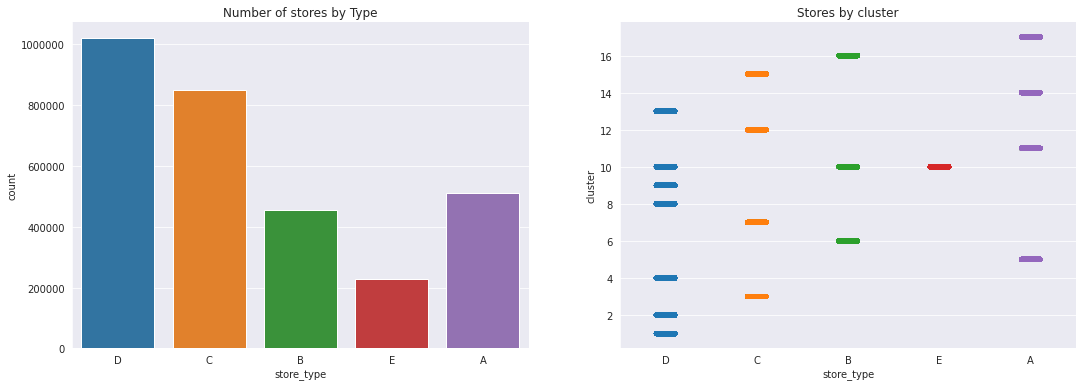

In [58]:
fig,axes = plt.subplots(1,2,figsize= (18,6))
sns.countplot(data= train_data,  x = "store_type", ax=axes[0])
axes[0].ticklabel_format(style='plain', axis='y')
axes[0].set_title("Number of stores by Type")
sns.stripplot(x="store_type", y= "cluster", data= train_data, ax = axes[1])
axes[1].set_title("Stores by cluster")
sns.despine();
plt.show()

`Observations` :     
* Type D stores are largest in number of the other five types of stores.
* Type E stores are the smallest in number.

The right side of the graph show the cluster ( grouping of similar stores) Number.


Type | Cluster Number
--- | ---
`A` | **5, 11, 14, 17**
`B` | **6, 10, 16**
`C` | **3, 7, 12, 15**
`D` | **1, 2, 4, 8, 9, 10, 13**
`E` | **10**




### 3. What are the Top 10 Products sold?

In [59]:
df = train_data.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales',ascending=False)[:15]
                                                                                        
df['color'] = '#71c7ec'
df['color'][2:] = '#107dac'

trace= go.Bar(x=df['sales'], y=df['family'],
               marker=dict(color= df['color']),
               name='Family', orientation='h')

fig = go.Figure(data = trace)
fig.layout.update({'title': 'Top 10 Product Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending')
fig.update_xaxes(visible=False)
fig.update_layout(title_x=0.5)
fig.show()

`Observations` :  
* Highest sales are made by the products like grocery and beverages.

### 4. How many items are on promotion at diffrent stores?    

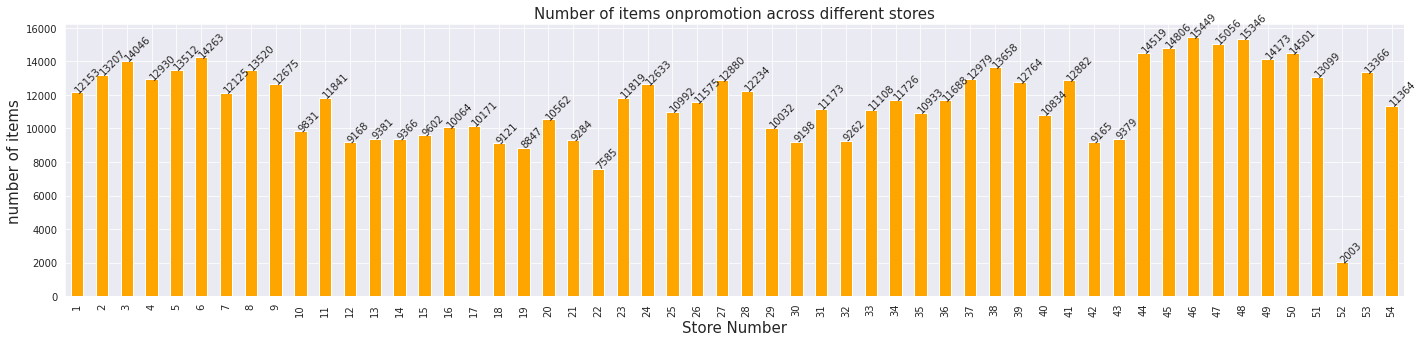

In [60]:
promotion_df=train_data[train_data['onpromotion'] > 0]

plt.ticklabel_format(style='plain')  
ax=promotion_df.groupby('store_nbr')['onpromotion'].count().plot(kind='bar',figsize=(24,5),color='orange')
plt.xlabel('Store Number',fontsize=15)
plt.title('Number of items onpromotion across different stores',fontsize=15)  
plt.ylabel('number of items',fontsize=15)  

for p in ax.patches:
   ax.annotate('{}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+6),rotation=45,fontsize=10)

plt.show()

`Observations` :    
Store number `44`, `45`, `46`, `47`, `48`, `50`  seems to have more number of items on promotion

### 5. What are the sales accross different states and cities?

In [61]:
import plotly.express as px
  
fig = px.sunburst(train_data, path=['state', 'city'], title='Sales across Different States and cities', values='sales', color='sales', color_continuous_midpoint=np.average(train_data['sales'], weights=train_data['sales']))
fig.show()

`Observations` :    

`State`| `City` | `Total Sales` | `Remark`
--- | --- | --- | --- 
Cotopaxi | Latacung | 21,182,246 | **Lowest sales**
Pichincha | Quito | 556,741,824 | **Highest sales**

### 6. What are the trends and distributions of Oil Price and Sales?
Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

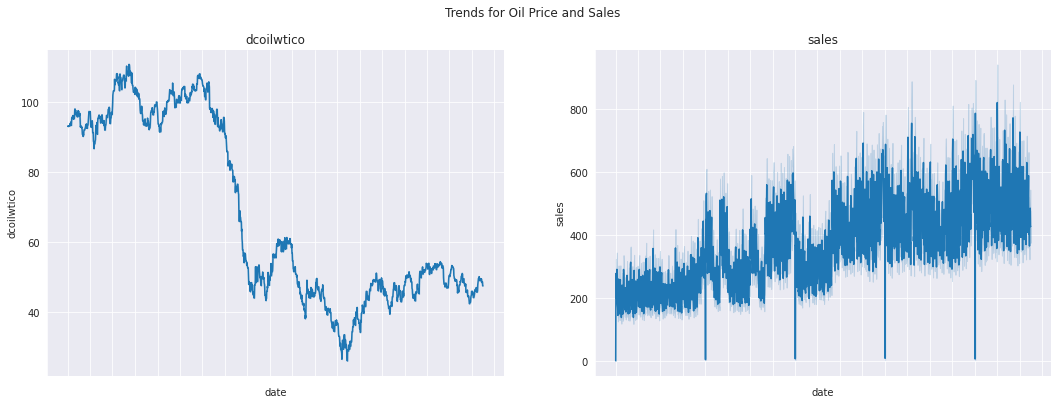

In [62]:
import matplotlib.dates as mdates

fig, axes = plt.subplots(1,2, figsize = (18,6))
fig.suptitle("Trends for Oil Price and Sales")

chart_features = ['dcoilwtico','sales']
years = mdates.YearLocator()   # every year,
months = mdates.MonthLocator((1,4,7,10))  # every quarter
yearsFmt = mdates.DateFormatter('%b-%Y')


for i, ax in enumerate(axes):
    sns.lineplot(data= train_data, x='date', y=chart_features[i],ax = axes[i])
    ax.set_title(ax.get_ylabel())
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor") # need to figure out labels
sns.despine();

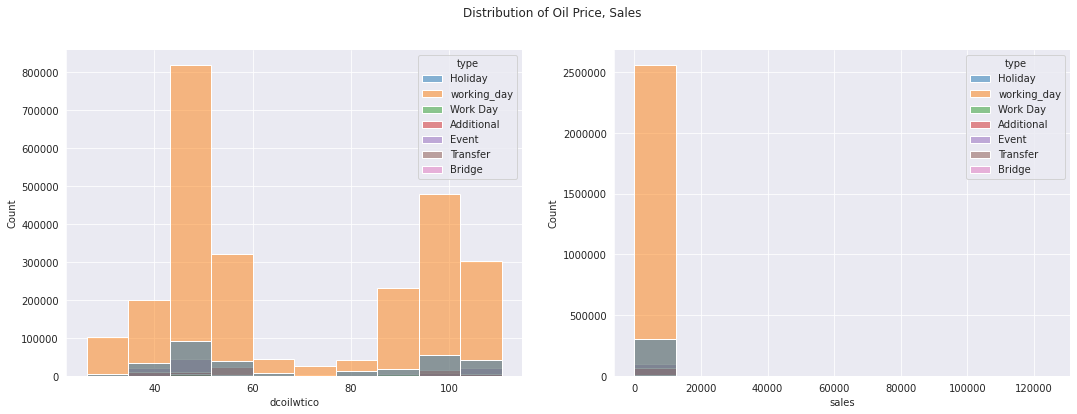

In [63]:
fig, axes = plt.subplots(1,2, figsize = (18,6))
fig.suptitle("Distribution of Oil Price, Sales")

plt.ticklabel_format(style='plain')

chart_features = ['dcoilwtico','sales']
for i, ax in enumerate(axes):
    sns.histplot(data= train_data, x=chart_features[i], hue="type", bins= 10, ax= axes[i])

sns.despine();

In [64]:
check_skew_df=train_data['sales'].copy()

In [65]:
check_skew_df.skew()

7.509946

`Observations` :     
From the above histogram of Sales column  the distribution Highly right skewed or positively skewed data. 
No need to apply log transformation to sales column.
Keeping the sales column as it is cause the evaluation metric is Mean Squared Logarithmic Error.

### 7. What are the Transactions at each Stores ?

In [66]:
transaction_stores_df = pd.merge(transaction_data, store_data, how = 'outer', on = 'store_nbr')

In [67]:
transaction_stores_df.sort_values('transactions', ascending = True, inplace=True)
transaction_stores_df.head(10)

,date,store_nbr,transactions,city,state,type,cluster
61301,2016-09-07,43,5,Esmeraldas,Esmeraldas,E,10
4380,2016-01-02,2,6,Quito,Pichincha,D,13
2703,2016-01-04,1,10,Quito,Pichincha,D,13
78964,2016-04-17,53,33,Manta,Manabi,D,13
78965,2016-04-18,53,54,Manta,Manabi,D,13
43014,2017-02-20,30,97,Guayaquil,Guayas,C,3
76277,2016-05-18,54,179,El Carmen,Manabi,C,3
42066,2014-07-11,30,203,Guayaquil,Guayas,C,3
27881,2016-05-18,16,238,Santo Domingo,Santo Domingo de los Tsachilas,C,3
64857,2017-04-03,45,292,Quito,Pichincha,A,11


In [68]:
fig = px.pie( transaction_stores_df,
                  values = transaction_stores_df['transactions'],
                  names = transaction_stores_df['cluster'],
                  color = transaction_stores_df['city'],
                  color_discrete_sequence=px.colors.sequential.Plasma_r
                  )
fig.update_layout( yaxis_title = 'Sum of Transaction',
                  xaxis_title = 'City',
                  title = 'Total store transactions per City classified as per types'              
                  )
fig.update_xaxes(dtick=1)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

`Observation` :     
* As can be seen from this pie chart, highest transaction is done by stores belonging to cluster 6 in Santo Domangio, followed by stores in same city but belonging to cluster 8 Quito. Least transactions is done by stores in city Rhiobamba belonging to cluster 16 Quito.

### 8. What are the average Sales Distribution across diffrent stores?

In [69]:
avg_sd = train_data.groupby([train_data.date.dt.year, "store_type"]).agg({"sales":"mean"}).sort_values('store_type', ascending=True).reset_index()

fig = px.box(avg_sd, y="sales", facet_col="store_type", color= 'store_type', boxmode="overlay", points='all')

fig.layout.update({'width':1000,'height':700})
fig.update_layout(title = "Average Sales Distribution")
fig.update_layout(title_x=0.3)
fig.show()

`Observation` :
* Store A has highest sales with the median of 719.7. Store A has the highest sales which is 38%.

* A > D > B > E > C this is the ranking of store types considering medians of sales.

# Data preparation

In [70]:
train_data.columns

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'store_type', 'cluster', 'type', 'locale', 'transferred',
       'dcoilwtico', 'year', 'month', 'day', 'weekday', 'is_holiday',
       'is_work_day', 'holiday_count', 'pay_day', 'prev_pay_day',
       'has_earthquake'],
      dtype='object')

In [71]:
train_data=train_data[['id', 'date', 'store_nbr', 'family', 'onpromotion', 'city',
                       'state', 'store_type', 'cluster', 'type', 'locale', 'transferred','dcoilwtico', 'year', 'month', 'day', 'weekday', 'is_holiday',
                      'is_work_day', 'holiday_count', 'pay_day', 'prev_pay_day','has_earthquake', 'sales']]

In [72]:
train_data.head()

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,type,...,month,day,weekday,is_holiday,is_work_day,holiday_count,pay_day,prev_pay_day,has_earthquake,sales
0,0,2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,Holiday,...,1,1,Tuesday,1,0,53460,0,0.0,0,0.0
1,0,2013-01-01,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,working_day,...,1,1,Tuesday,1,0,53460,0,0.0,0,0.0
2,1,2013-01-01,1,BABY_CARE,0,Quito,Pichincha,D,13,Holiday,...,1,1,Tuesday,1,0,53460,0,0.0,0,0.0
3,1,2013-01-01,1,BABY_CARE,0,Quito,Pichincha,D,13,working_day,...,1,1,Tuesday,1,0,53460,0,0.0,0,0.0
4,2,2013-01-01,1,BEAUTY,0,Quito,Pichincha,D,13,Holiday,...,1,1,Tuesday,1,0,53460,0,0.0,0,0.0


In [73]:
test_data.head()

,id,date,store_nbr,family,onpromotion,city,state,store_type,cluster,type,...,year,month,day,weekday,is_holiday,is_work_day,holiday_count,pay_day,prev_pay_day,has_earthquake
0,-13768,2017-08-16,1,AUTOMOTIVE,0,Quito,Pichincha,D,13,working_day,...,2017,8,16,Wednesday,1,0,28512,0,0.0,0
1,-13767,2017-08-16,1,BABY_CARE,0,Quito,Pichincha,D,13,working_day,...,2017,8,16,Wednesday,1,0,28512,0,0.0,0
2,-13766,2017-08-16,1,BEAUTY,2,Quito,Pichincha,D,13,working_day,...,2017,8,16,Wednesday,1,0,28512,0,0.0,0
3,-13765,2017-08-16,1,BEVERAGES,20,Quito,Pichincha,D,13,working_day,...,2017,8,16,Wednesday,1,0,28512,0,0.0,0
4,-13764,2017-08-16,1,BOOKS,0,Quito,Pichincha,D,13,working_day,...,2017,8,16,Wednesday,1,0,28512,0,0.0,0


## **Taking 2% sample of the data**

In [74]:
sample_train_data=train_data.sample(frac=0.02,random_state=42).copy()

In [75]:
year = pd.to_datetime(sample_train_data.date).dt.year

train_df = sample_train_data[year < 2016]
val_df = sample_train_data[year == 2017]
test_df = test_data

In [76]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (39577, 24)
val_df.shape : (8273, 24)
test_df.shape : (28512, 23)


## Input and Target Columns

Let's identify the input and target columns.

In [77]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'sales'

In [78]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

In [79]:
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

In [80]:
test_inputs = test_df[input_cols].copy()

Let's also identify the numeric and categorical columns.

In [81]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes(['object','bool']).columns.tolist()

In [82]:
print(numeric_cols)

['store_nbr', 'onpromotion', 'cluster', 'dcoilwtico', 'year', 'month', 'day', 'is_holiday', 'is_work_day', 'holiday_count', 'pay_day', 'prev_pay_day', 'has_earthquake']


In [83]:
print(categorical_cols)

['family', 'city', 'state', 'store_type', 'type', 'locale', 'transferred', 'weekday']


## Scaling Numeric Features

In [84]:
from sklearn.preprocessing import MinMaxScaler

In [85]:
scaler = MinMaxScaler().fit(sample_train_data[numeric_cols])

In [86]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [87]:
val_inputs.describe().loc[['min', 'max']]

,store_nbr,onpromotion,cluster,dcoilwtico,year,month,day,is_holiday,is_work_day,holiday_count,pay_day,prev_pay_day,has_earthquake
min,0.0,0.000000,0.0,0.192941,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,0.351551,1.0,0.335070,1.0,0.636364,1.0,1.0,1.0,0.9,1.0,1.0,0.0


## Encoding Categorical Data

In [88]:
from sklearn.preprocessing import OneHotEncoder

In [89]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(sample_train_data[categorical_cols])

In [90]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))

In [91]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

As a final step, let's drop the textual categorical columns, so that we're left with just numeric data.

In [92]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

# Kaggle Predict and Submition file

In [93]:
def predict_and_submit(model,fname):
  
  future_sales = model.fit(X_train, train_targets).predict(X_test)
  sub_df = pd.read_csv('/content/store-sales-time-series-forecasting/sample_submission.csv')
  sub_df['sales'] = future_sales
  sub_df.to_csv(fname, index=None)
  return sub_df

# Base Model

## Linear Regressor

In [94]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

In [95]:
reg = LinearRegression().fit(X_train, train_targets)

In [96]:
val_preds=reg.predict(X_val)

In [97]:
#The val_predictions have neagtive values , replacing them with zero
new_list = [0 if i < 0 else i for i in val_preds]

In [98]:
mean_squared_log_error(val_targets, new_list, squared=False)

2.496478813237759

## Ridge

In [100]:
from sklearn.linear_model import Ridge

In [101]:
rdg_model = Ridge()
rdg_model.fit(X_train, train_targets)

Ridge()

In [102]:
rdg_v_preds = rdg_model.predict(X_val)

In [103]:
#The val_predictions have neagtive values , replacing them with zero
rgd_val_predictions = [0 if i < 0 else i for i in rdg_v_preds]

mean_squared_log_error(val_targets, rgd_val_predictions, squared=False)

2.525493944716415

In [104]:
predict_and_submit(LinearRegression(),'base_model_forecast.csv')

,id,sales
0,3000888,113.750
1,3000889,104.250
2,3000890,157.000
3,3000891,2461.750
4,3000892,114.250
...,...,...
28507,3029395,409.375
28508,3029396,184.125
28509,3029397,808.125
28510,3029398,294.875


# Model Selection

In [105]:
def try_model(model):

    from sklearn.metrics import mean_squared_log_error
    # Fit the model
    model.fit(X_train, train_targets)
 
    # Generate predictions
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_val)
    
    # If the prediciton contains negative vales then they are replaced with zero 
    train_list = [0 if i < 0 else i for i in train_preds]
    val_list = [0 if i < 0 else i for i in val_preds]
    
    # Compute Errors or loss
    train_error = mean_squared_log_error(train_targets, train_list, squared=False)
    val_error = mean_squared_log_error(val_targets, val_list, squared=False)

    #Feature importance
    importance_df = pd.DataFrame({  'feature': X_train.columns, 'importance': model.feature_importances_  }).sort_values('importance', ascending=False)
    

    return print("Train_set Error :",train_error ),print("Validation_set Error :",val_error ) , sns.barplot(data=importance_df.head(10), x='importance', y='feature').set(title='Feature Importance');

Train_set Error : 8.914929447982509e-08
Validation_set Error : 1.5697862502362578
CPU times: user 1.11 s, sys: 649 µs, total: 1.11 s
Wall time: 1.13 s


(None, None, [Text(0.5, 1.0, 'Feature Importance')])

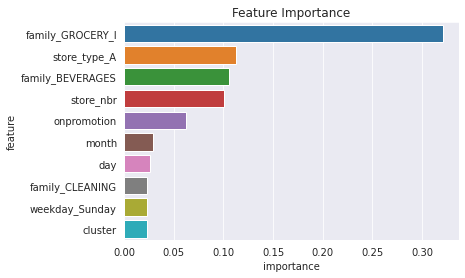

In [106]:
%%time
try_model(DecisionTreeRegressor())

[00:50:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train_set Error : 2.524040091444358
Validation_set Error : 1.9499956105220513
CPU times: user 10.4 s, sys: 156 ms, total: 10.5 s
Wall time: 10.6 s


(None, None, [Text(0.5, 1.0, 'Feature Importance')])

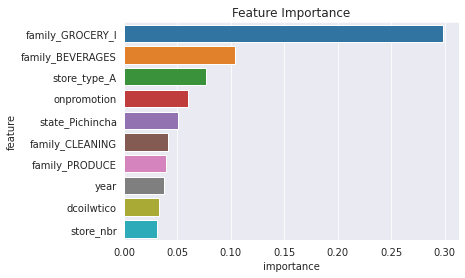

In [107]:
%%time
try_model(XGBRegressor())

Train_set Error : 0.7431072289859387
Validation_set Error : 1.0864388324530918
CPU times: user 1min 7s, sys: 315 ms, total: 1min 8s
Wall time: 1min 8s


(None, None, [Text(0.5, 1.0, 'Feature Importance')])

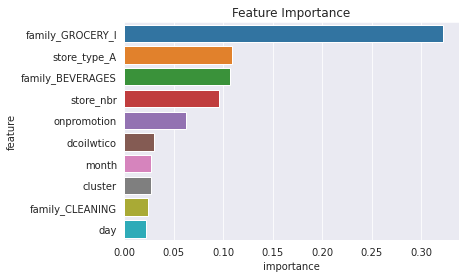

In [108]:
%%time
try_model(RandomForestRegressor())

From the above results Random Forest Regressor gives the least error for the Validation set


In [109]:
predict_and_submit(RandomForestRegressor(),'Random_Forest_Resgressor_forecast.csv')

,id,sales
0,3000888,4.640000
1,3000889,0.100000
2,3000890,28.516580
3,3000891,2168.990000
4,3000892,0.080000
...,...,...
28507,3029395,416.015793
28508,3029396,76.346960
28509,3029397,1511.334262
28510,3029398,127.115544


# Hyperparameter Tuning with Random Forests

In [110]:
model = RandomForestRegressor().fit(X_train, train_targets)

In [111]:
mean_squared_log_error(model.predict(X_val), val_targets, squared=False)

1.1053873906996705

In [112]:
model.get_params(deep=True)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [120]:
def test_params(**params):
    model = RandomForestRegressor(random_state=42, n_jobs=-1, **params).fit(X_train, train_targets)
    train_rmsle = mean_squared_log_error(model.predict(X_train), train_targets, squared=False)
    val_rmsle = mean_squared_log_error(model.predict(X_val), val_targets, squared=False)
    return train_rmsle, val_rmsle

In [123]:
def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    for value in param_values:
        params = {param_name: value}
        train_rmsle, val_rmsle = test_params(**params)
        train_errors.append(train_rmsle)
        val_errors.append(val_rmsle)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

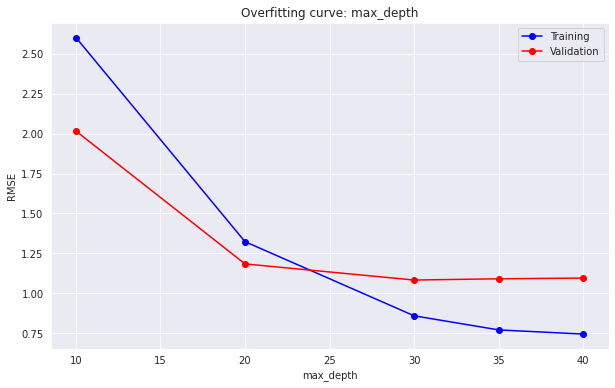

In [124]:
test_param_and_plot('max_depth', [10, 20, 30, 35, 40])

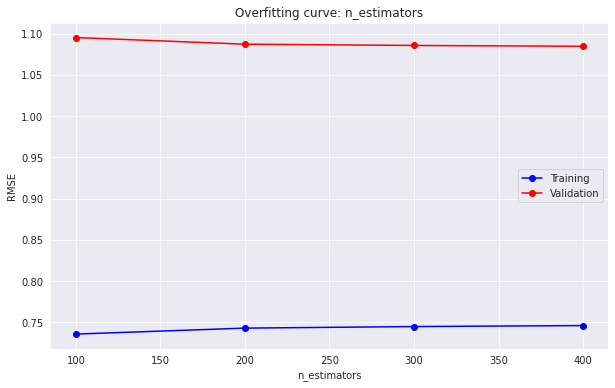

In [125]:
test_param_and_plot('n_estimators', [100,200,300,400])

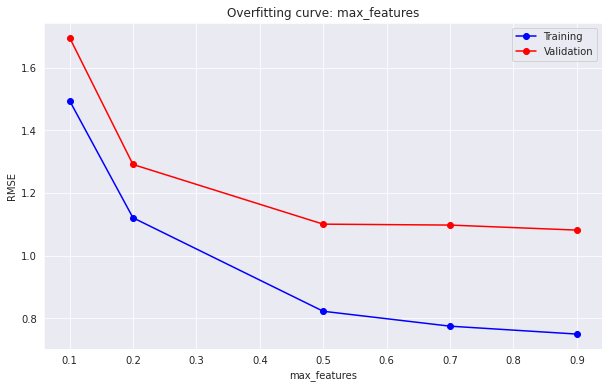

In [126]:
test_param_and_plot('max_features', [0.1,0.2,0.5,0.7,0.9])

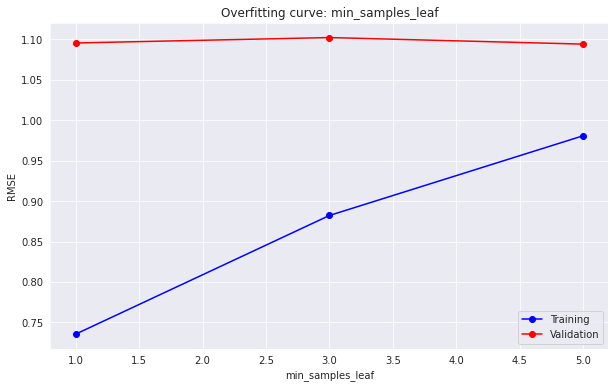

In [127]:
test_param_and_plot('min_samples_leaf', [1,3,5])

In [128]:
test_params( max_depth= 25, max_features = 0.7, min_samples_leaf =1, min_samples_split= 2)

(1.0419692291377014, 1.085587731133341)

In [129]:
test_params( max_depth= 30, max_features = 'auto', min_samples_leaf =1, min_samples_split= 2)

(0.8586890399450189, 1.0828163402507482)

In [130]:
test_params( max_depth= 30, n_estimators=50, min_samples_leaf =1, min_samples_split= 2)

(0.8481939126656336, 1.0892692109537445)

In [131]:
predict_and_submit(RandomForestRegressor(random_state=42,
                                         max_depth= 40,
                                         max_features = 0.9,
                                         min_samples_leaf =1,
                                         min_samples_split= 2 ) , 'hyperparameter_randomForestRegressor_forecast.csv')

,id,sales
0,3000888,4.834454
1,3000889,0.067247
2,3000890,46.221610
3,3000891,2333.140000
4,3000892,0.059318
...,...,...
28507,3029395,455.734540
28508,3029396,73.376100
28509,3029397,1565.557332
28510,3029398,187.435494


# Exponential Weighted Moving Average

Moving Average (MA) is one of the most and commonly used strategy in marketing analysis. It has two types Simple Moving Average (SMA) and Exponential Moving Average (EMA). To learn more about moving average refer to this [video](https://youtu.be/Kt-6PfYg_II).


$$ EMA = [Current Sales * e] + [Previous EMA * (1-e)]$$

where:

$e = 2/(Totaldays +1)$

In [132]:
# Date Features
def create_date_features_Date(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    return df
    
# Exponentially Weighted Average Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [133]:
# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feature_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feature_imp[0:25])
        plt.title('Important Features')
        plt.tight_layout()
        plt.show()
    else:
        print(feature_imp.head(num)) 

Let's load up the data again and add the EMA features

In [134]:
df_train = pd.read_csv("/content/store-sales-time-series-forecasting/train.csv",index_col=0)
df_test = pd.read_csv("/content/store-sales-time-series-forecasting/test.csv",index_col=0)
df_transactions = pd.read_csv("/content/store-sales-time-series-forecasting/transactions.csv")
df_stores = pd.read_csv("/content/store-sales-time-series-forecasting/stores.csv")
df_holidays = pd.read_csv("/content/store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv("/content/store-sales-time-series-forecasting/oil.csv")

In [135]:
import numpy as np
df_oil.dcoilwtico[0]=93.00

for i in list(df_oil[df_oil.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([df_oil.dcoilwtico[p],
                  df_oil.dcoilwtico[c]])
  df_oil.dcoilwtico[i]=mean

df_oil.dcoilwtico[1174]=46.02
df_oil.dcoilwtico[1175]=46.02
df_oil['date'] = df_oil['date'].astype("datetime64")

In [136]:
df_date = pd.DataFrame(pd.date_range("2013-01-01","2017-08-31"),columns=["date"])
df_oil = df_date.merge(df_oil,left_on='date',right_on='date',how='left').fillna(method='ffill').fillna(method='bfill')

df_all = df_train.append(df_test)
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")

df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")

df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],
                      right_on=["date","store_nbr"],how="left")

df_all["date"] = df_all["date"].astype("datetime64")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace(",","_",regex=True)

#Rename the date column
df_all = df_all.rename(columns = {"date":"Date"})

In [137]:
col = ['Date','store_nbr','family','sales','onpromotion','city', 'state', 'type', 'locale_name','cluster','Holiday_type','locale','description', 'transferred','dcoilwtico']

df = df_all[col]

In [138]:
df["store_nbr"] = df["store_nbr"].astype("category")
df["family"] = df["family"].astype("category")
df["onpromotion"] = df["onpromotion"].astype("int64")
df["city"] = df["city"].astype("category")#
df["state"] = df["state"].astype("category")#
df["type"] = df["type"].astype("category")#
df["Holiday_type"] = df["Holiday_type"].astype("category")
df["locale"] = df["locale"].astype("category")
df["locale_name"] = df["locale_name"].astype("category")#
df["description"] = df["description"].astype("category")
df["transferred"] = df["transferred"].astype("category")

######################### 
df = create_date_features_Date(df)
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 6, 7, 8, 30]
df = ewm_features(df, alphas, lags)
#######################

df['sales'] = np.log1p(df["sales"].values) #Logarithmic Conversion 

Now we will split the data in Train/Val/Test using dates.

* Train: 1 JAN 2013 - 1 OCT 2017 (99.9%)

* Validation : 2 OCT 2017 - 15 OCT 2017 (0.1%)

* Test will be having original test dates data.

In [139]:
#Train Test Split
df= df[df["Date"]>"2012-12-31"]
val = df[(df["Date"]>"2017-08-01")&(df["Date"]<="2017-08-15")]
train  = df[df["Date"]<="2017-08-01"]
test = df[df["Date"]>"2017-08-15"]

col_X = [col for col in train.columns if col not in ['Date', 'sales','year']]

y_train = train["sales"]
y_val = val["sales"]
X_train = train[col_X]
X_val = val[col_X]
X_test = test[col_X]
y_test = test["sales"] 

## Training with LightGBM

In [140]:
import lightgbm as lgb


In [141]:
# LightGBM parameters
lgb_params = {'metric': {'mse'},
              'boosting_type' : 'gbdt',
              'num_leaves': 8,
              'learning_rate': 0.2,
              #'feature_fraction': 0.8,
              'max_depth': 7,
              'verbose': 0,
              'num_boost_round': 5000,
              'early_stopping_rounds': 200,
              'nthread': -1,
             'force_col_wise':True}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=col_X)
lgbtest = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=col_X)

In [142]:
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l2: 0.155706	valid_1's l2: 0.162394
[400]	training's l2: 0.145758	valid_1's l2: 0.155851
[600]	training's l2: 0.140009	valid_1's l2: 0.152499
[800]	training's l2: 0.135889	valid_1's l2: 0.149843
[1000]	training's l2: 0.13302	valid_1's l2: 0.147694
[1200]	training's l2: 0.130914	valid_1's l2: 0.146494
[1400]	training's l2: 0.128992	valid_1's l2: 0.145386
[1600]	training's l2: 0.12721	valid_1's l2: 0.144632
[1800]	training's l2: 0.125958	valid_1's l2: 0.143559
[2000]	training's l2: 0.1248	valid_1's l2: 0.142802
[2200]	training's l2: 0.123793	valid_1's l2: 0.142442
[2400]	training's l2: 0.122895	valid_1's l2: 0.142212
[2600]	training's l2: 0.122081	valid_1's l2: 0.141954
[2800]	training's l2: 0.12125	valid_1's l2: 0.141631
[3000]	training's l2: 0.120437	valid_1's l2: 0.141492
[3200]	training's l2: 0.119748	valid_1's l2: 0.141433
[3400]	training's l2: 0.119076	valid_1's l2: 0.141274
[3600]	training's l2: 0.1184

In [143]:
def rmsle(y_true, y_pred):
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

In [144]:
#Helper function for evaluation metric
from sklearn.metrics import mean_squared_log_error
pd.options.display.float_format = '{:,.2f}'.format

def eval_metrics(targets, pred):

  # Targets = Train targets or Val targets (tarin_targets / val_targets)
  # pred = model predicts

   rmsle = round(mean_squared_log_error(targets, pred, squared= False),3)

   return {'RMSLE': rmsle}

In [145]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val[y_pred_val<0]=0
eval_metrics(np.expm1(y_val), np.expm1(y_pred_val))

{'RMSLE': 0.376}

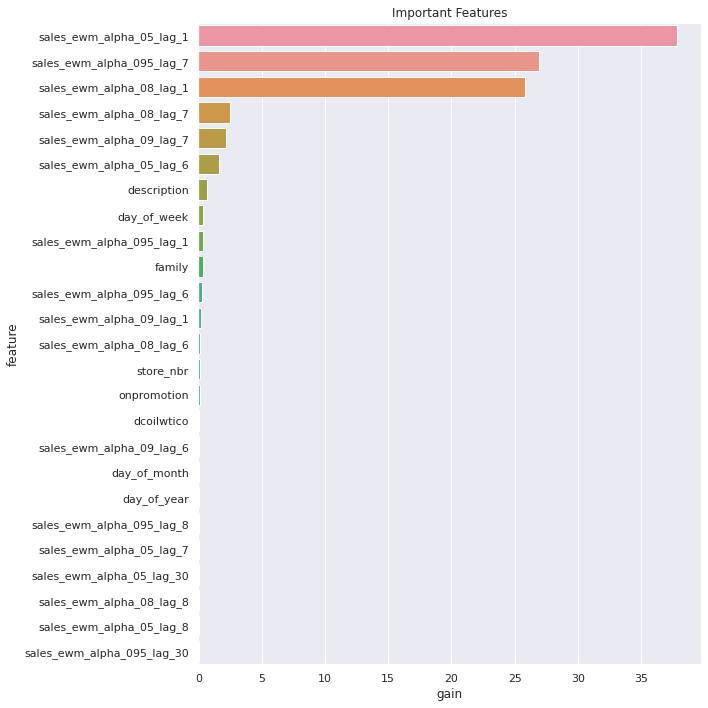

In [146]:
plot_lgb_importances(model, plot=True)

In [147]:
submission = pd.read_csv("./store-sales-time-series-forecasting/sample_submission.csv")
y_test = model.predict(X_test, num_iteration=model.best_iteration)
y_test[y_test<0]=0
submission["sales"] = np.expm1(y_test)

Writing the results into `final_submission` .csv file

In [148]:
submission.to_csv("final_submission.csv",index=False)
submission

,id,sales
0,3000888,3.96
1,3000889,0.00
2,3000890,5.50
3,3000891,"2,459.76"
4,3000892,0.03
...,...,...
28507,3029395,413.16
28508,3029396,127.94
28509,3029397,"1,790.61"
28510,3029398,114.04


# Conclusion
1. Base Model (Linear Regression)  
The private leaderboard score for the Linear Regression model was 2.11573

2. Random Forest Regressor    
The private leaderboard score for the Random Foerst Regressor model was 0.89513

3. Exponential Moving Average:          
The public leaderboard score for the EMA was 0.44556 

<img src='https://drive.google.com/uc?export=view&id=1xVhc7wLwmzkQzaSy5C8ra6RGlLxu4diQ' width=1000px>


# Summary & Insights

In this project, we have compared Decision tree regressor, Random forest regressor and XGB regressor models. A fraction of training data (0.02 of total training data), was used to train the model because of the low memory issue. Following are the major conclusion of this study.

- EDA is an important step to develop insights on the given data.
- Feature engineering helps in transforming the data in format that is best fit for fitting into a model.
- Its always a good idea to compare two or more models to obtain best results.
- It is found that after hypertuning the parameters, the training loss for training and bigger training dataset has significantly improved when measured against the RMSLE loss.
- Gradient Boosting gives the best result for validation loss for RMSLE as compared to Decision Tree Regressor or Random Forest Regressor.
- Whole training data must be used to get the best Kaggle score.

#Future Work

1. Implement more models to improve score like ARIMA.

2. Can extract features from the target variable such as aggregrate, rolling stats since we have time-series data.

3. Will work on Unsupurvised Machine Learning problems.

4. Work on Deep learning and NLP projects.

# References

*   Linear Regression : https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/linear-regression-with-scikit-learn
  
*   Decision Trees and Random Forests : https://jovian.com/learn/zero-to-data-analyst-bootcamp/lesson/decision-trees-and-random-forests

*   Gradient Boosting Machines with XGBoost : https://jovian.ai/learn/zero-to-data-analyst-bootcamp/lesson/gradient-boosting-machines-with-xgboost

*   Stackoverflow and Geeksforgeeks

*   https://www.youtube.com/watch?v=Kt-6PfYg_II

**Documentaion**

[1]. Scikit Learn Supervised Learning [Doc](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)  

[2]. Light GBM [Doc](https://lightgbm.readthedocs.io/en/latest/)  

[3]. XGBoost [Doc](https://xgboost.readthedocs.io/en/latest/)

[4]. RMSLE [Doc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html)

**Tutorials**

[5]. How to approach Machine Learning Problems 
[Jovian Aakash N S](https://jovian.ai/learn/zero-to-data-analyst-bootcamp)

[6]. Exponential Moving Average: [Video](https://youtu.be/Kt-6PfYg_II)


**Blogs and Kaggle Kernels**

[7]. Algorithm to find best moving average, Gianluca Malato: [Link](https://towardsdatascience.com/an-algorithm-to-find-the-best-moving-average-for-stock-trading-1b024672299c)

[8]. Store Sales TS Forecasting - A Comprehensive Guide, EKREM BAYAR: [Link](https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide/notebook#11.-Exponential-Moving-Average)

[9]. Time Series Analysis, KASHISH RASTOGI: [Link](https://www.kaggle.com/code/kashishrastogi/store-sales-analysis-time-serie?scriptVersionId=81112640)

[10]. More Data Info: [Link](https://rpubs.com/yongks/favorita)

[11]. Walmart Store Sales Forecasting, Anushree: [Link](https://jovian.ai/anushree-k/final-walmart-simple-rf-gbm#C0)


**Queries**

[12]. ChatGPT,StackOverflow, GeekforGeeks